<a href="https://colab.research.google.com/github/dasomeda/cctv/blob/main/RoseTTAFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RoseTTAFold2 (WIP)**
RoseTTAFold2 is a method for protein structure prediction.


#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use ":" to specify multimeric input, (eg. sequence="AAA:AAA")
- See detailed instructions at the end.


**<font color="red">NOTE:</font>** This notebook is in active development, we are still working on adding all the options (such as template inputs) from the [manuscript](https://www.biorxiv.org/content/10.1101/2023.05.24.542179v1). Use at your own risk!


In [1]:
%%time
#@title setup **RoseTTAFold2** (~1m)
params = "RF2_apr23" # @param ["RF2_apr23","RF2_jan24"]

import os, time, sys
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

if params == "RF2_jan24" and not os.path.isfile(f"{params}.tgz"):
  # send param download into background
  os.system("(apt-get install aria2; aria2c -q -x 16 https://files.ipd.uw.edu/dimaio/RF2_jan24.tgz) &")

if params == "RF2_apr23" and not os.path.isfile(f"{params}.tgz"):
  # send param download into background
  os.system("(apt-get install aria2; aria2c -q -x 16 https://files.ipd.uw.edu/dimaio/RF2_apr23.tgz) &")

if not os.path.isdir("RoseTTAFold2"):
  print("install RoseTTAFold2")
  os.system("git clone https://github.com/uw-ipd/RoseTTAFold2.git")
  os.system("pip install py3Dmol")

  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  # 25Aug2025: updating dgi install to work with latest pytorch
  os.system("pip install --no-dependencies dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html")
  os.system("pip install --no-dependencies e3nn==0.5.5 opt_einsum_fx")
  os.system("cd RoseTTAFold2/SE3Transformer; pip install .")

  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")

  #os.system("pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html")
  #os.system("cd RoseTTAFold2/SE3Transformer; pip -q install --no-cache-dir -r requirements.txt; pip -q install .")
  #os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/beta/colabfold/mmseqs/api.py")

  # install hhsuite
  print("install hhsuite")
  os.makedirs("hhsuite", exist_ok=True)
  os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

if not os.path.isfile(f"{params}.pt"):
  time.sleep(5)

if os.path.isfile(f"{params}.tgz.aria2"):
  print("downloading RoseTTAFold2 params")
  while os.path.isfile(f"{params}.tgz.aria2"):
    time.sleep(5)

if not os.path.isfile(f"{params}.pt"):
  os.system(f"tar -zxvf {params}.tgz")
  if params == "RF2_apr23":
    os.system(f"mv weights/{params}.pt .")

if not "IMPORTED" in dir():
  if 'RoseTTAFold2/network' not in sys.path:
    os.environ["DGLBACKEND"] = "pytorch"
    sys.path.append('RoseTTAFold2/network')
  if "hhsuite" not in os.environ['PATH']:
    os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

  import matplotlib.pyplot as plt
  from google.colab import files
  import numpy as np
  from parsers import parse_a3m
  #from api import run_mmseqs2
  from colabfold_utils import run_mmseqs2
  import py3Dmol
  import torch
  from string import ascii_uppercase, ascii_lowercase
  import hashlib, re, os
  import random

  def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
  alphabet_list = list(ascii_uppercase+ascii_lowercase)
  from collections import OrderedDict, Counter

  IMPORTED = True

if not "pred" in dir() or params_sele != params:
  from predict import Predictor
  print("compile RoseTTAFold2")

  if (torch.cuda.is_available()):
    pred = Predictor(f"{params}.pt", torch.device("cuda:0"))
  else:
    print ("WARNING: using CPU")
    pred = Predictor(f"{params}.pt", torch.device("cpu"))
  params_sele = params

def get_unique_sequences(seq_list):
    unique_seqs = list(OrderedDict.fromkeys(seq_list))
    return unique_seqs

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabfold/rosettafold2"
  return run_mmseqs2(*args, **kwargs)

def get_msa(seq, jobname, cov=50, id=90, max_msa=2048,
            mode="unpaired_paired"):

  assert mode in ["unpaired","paired","unpaired_paired"]
  seqs = [seq] if isinstance(seq,str) else seq

  # collapse homooligomeric sequences
  counts = Counter(seqs)
  u_seqs = list(counts.keys())
  u_nums = list(counts.values())

  # expand homooligomeric sequences
  first_seq = "/".join(sum([[x]*n for x,n in zip(u_seqs,u_nums)],[]))
  msa = [first_seq]

  path = os.path.join(jobname,"msa")
  os.makedirs(path, exist_ok=True)
  if mode in ["paired","unpaired_paired"] and len(u_seqs) > 1:
    print("getting paired MSA")
    out_paired = run_mmseqs2_wrapper(u_seqs, f"{path}/", use_pairing=True)
    headers, sequences = [],[]
    for a3m_lines in out_paired:
      n = -1
      for line in a3m_lines.split("\n"):
        if len(line) > 0:
          if line.startswith(">"):
            n += 1
            if len(headers) < (n + 1):
              headers.append([])
              sequences.append([])
            headers[n].append(line)
          else:
            sequences[n].append(line)
    # filter MSA
    with open(f"{path}/paired_in.a3m","w") as handle:
      for n,sequence in enumerate(sequences):
        handle.write(f">n{n}\n{''.join(sequence)}\n")
    os.system(f"hhfilter -i {path}/paired_in.a3m -id {id} -cov {cov} -o {path}/paired_out.a3m")
    with open(f"{path}/paired_out.a3m","r") as handle:
      for line in handle:
        if line.startswith(">"):
          n = int(line[2:])
          xs = sequences[n]
          # expand homooligomeric sequences
          xs = ['/'.join([x]*num) for x,num in zip(xs,u_nums)]
          msa.append('/'.join(xs))

  if len(msa) < max_msa and (mode in ["unpaired","unpaired_paired"] or len(u_seqs) == 1):
    print("getting unpaired MSA")
    out = run_mmseqs2_wrapper(u_seqs,f"{path}/")
    Ls = [len(seq) for seq in u_seqs]
    sub_idx = []
    sub_msa = []
    sub_msa_num = 0
    for n,a3m_lines in enumerate(out):
      sub_msa.append([])
      with open(f"{path}/in_{n}.a3m","w") as handle:
        handle.write(a3m_lines)
      # filter
      os.system(f"hhfilter -i {path}/in_{n}.a3m -id {id} -cov {cov} -o {path}/out_{n}.a3m")
      with open(f"{path}/out_{n}.a3m","r") as handle:
        for line in handle:
          if not line.startswith(">"):
            xs = ['-'*l for l in Ls]
            xs[n] = line.rstrip()
            # expand homooligomeric sequences
            xs = ['/'.join([x]*num) for x,num in zip(xs,u_nums)]
            sub_msa[-1].append('/'.join(xs))
            sub_msa_num += 1
      sub_idx.append(list(range(len(sub_msa[-1]))))

    while len(msa) < max_msa and sub_msa_num > 0:
      for n in range(len(sub_idx)):
        if len(sub_idx[n]) > 0:
          msa.append(sub_msa[n][sub_idx[n].pop(0)])
          sub_msa_num -= 1
        if len(msa) == max_msa:
          break

  with open(f"{jobname}/msa.a3m","w") as handle:
    for n,sequence in enumerate(msa):
      handle.write(f">n{n}\n{sequence}\n")

install RoseTTAFold2
install hhsuite


/content/RoseTTAFold2/network/SE3_network.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


compile RoseTTAFold2
CPU times: user 15.8 s, sys: 1.78 s, total: 17.6 s
Wall time: 1min 16s


In [7]:
#@title ###run **RoseTTAFold2**
sequence = "RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISDCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRNSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVYF " #@param {type:"string"}
jobname = "omicron_RBD" #@param {type:"string"}

#@markdown symmetry settings
sym = "X" #@param ["X","C", "D", "T", "I", "O"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
msa_concat_mode = "diag" #@param ["diag", "repeat", "default"]

#@markdown msa settings
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence","custom_a3m"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
collapse_identical = False #@param {type:"boolean"}

#@markdown RoseTTAFold2 settings
num_recycles = 6 #@param [0, 1, 3, 6, 12, 24] {type:"raw"}

#@markdown stochastic settings
use_mlm = False #@param {type:"boolean"}
use_dropout = False #@param {type:"boolean"}
max_msa = 256 #@param [16, 32, 64, 128, 256, 512] {type:"raw"}
random_seed = 0 #@param {type:"integer"}
num_models = 1 #@param ["1", "5", "10", "15", "20", "25"] {type:"raw"}

# process
max_extra_msa = max_msa * 8

sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)

if sym in ["X","C"]:
  copies = order
elif sym in ["D"]:
  copies = order * 2
else:
  copies = {"T":12,"O":24,"I":60}[sym]
  order = ""
symm = sym + str(order)

sequences = sequence.replace(":","/").split("/")
if collapse_identical:
  u_sequences = get_unique_sequences(sequences)
else:
  u_sequences = sequences
sequences = sum([u_sequences] * copies,[])
lengths = [len(s) for s in sequences]

# TODO
#subcrop = 1000 if sum(lengths) > 1400 else -1

subcrop = -1
topk = 1536


sequence = "/".join(sequences)
jobname = jobname+"_"+symm+"_"+get_hash(sequence)[:5]

print(f"jobname: {jobname}")
print(f"lengths: {lengths}")

os.makedirs(jobname, exist_ok=True)
if msa_method == "mmseqs2":
  get_msa(u_sequences, jobname, mode=pair_mode, max_msa=max_extra_msa)

elif msa_method == "single_sequence":
  u_sequence = "/".join(u_sequences)
  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write(f">{jobname}\n{u_sequence}\n")

elif msa_method == "custom_a3m":
  print("upload custom a3m")
  msa_dict = files.upload()
  lines = msa_dict[list(msa_dict.keys())[0]].decode().splitlines()
  a3m_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      a3m_lines.append(line)

  with open(f"{jobname}/msa.a3m","w") as a3m:
    a3m.write("\n".join(a3m_lines))

best_plddt = None
best_seed = None
for seed in range(random_seed,random_seed+num_models):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  npz = f"{jobname}/rf2_seed{seed}_00.npz"
  pred.predict(inputs=[f"{jobname}/msa.a3m"],
               out_prefix=f"{jobname}/rf2_seed{seed}",
               symm=symm,
               ffdb=None, #TODO (templates),
               n_recycles=num_recycles,
               msa_mask=0.15 if use_mlm else 0.0,
               msa_concat_mode=msa_concat_mode,
               nseqs=max_msa,
               nseqs_full=max_extra_msa,
               subcrop=subcrop,
               topk=topk,
               is_training=use_dropout)
  plddt = np.load(npz)["lddt"].mean()
  if best_plddt is None or plddt > best_plddt:
    best_plddt = plddt
    best_seed = seed

jobname: omicron_RBD_X1_1b5ca
lengths: [223]
getting unpaired MSA


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


N=36 L=223
recycle 0 plddt 0.657 pae 11.867 rmsd 22.450
recycle 1 plddt 0.703 pae 10.781 rmsd 2.910
recycle 2 plddt 0.707 pae 10.773 rmsd 2.881
recycle 3 plddt 0.732 pae 9.641 rmsd 2.654
recycle 4 plddt 0.762 pae 8.875 rmsd 0.592
recycle 5 plddt 0.767 pae 8.805 rmsd 0.375
recycle 6 plddt 0.772 pae 8.695 rmsd 0.338
runtime=17.57 vram=1.04


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

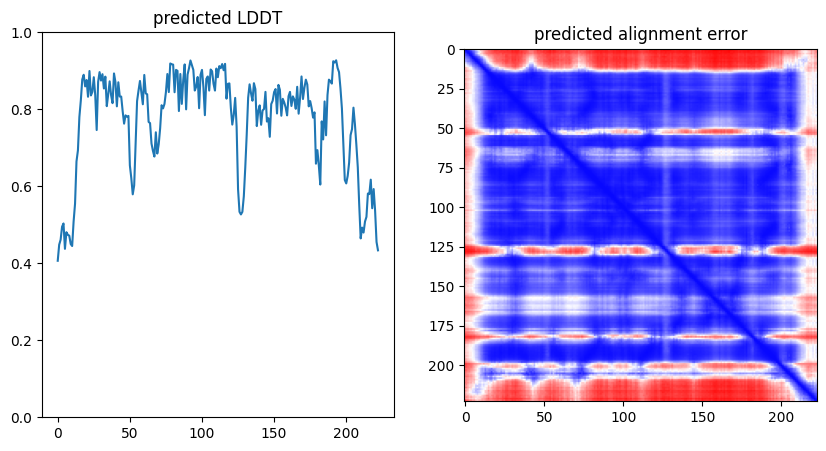

In [8]:
#@title Display 3D structure {run: "auto"}
color = "plddt" #@param ["plddt","chain","rainbow"]
import py3Dmol
import matplotlib
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]
pymol_cmap = matplotlib.colors.ListedColormap(pymol_color_list)

def plot_pdb(pdb, color="plddt"):
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(pdb,'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,c in zip(range(len(lengths)),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':c}})
  else:
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  view.zoomTo()
  view.show()

plot_pdb(f"{jobname}/rf2_seed{best_seed}_00_pred.pdb", color=color)
output = dict(np.load(f"{jobname}/rf2_seed{best_seed}_00.npz"))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("predicted LDDT")
plt.plot(output["lddt"])
plt.ylim(0,1.0)
plt.subplot(1,2,2)
plt.title("predicted alignment error")
plt.imshow(output["pae"],vmin=0,vmax=30,cmap="bwr")
plt.show()

In [9]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = f"{jobname}/settings.txt"
with open(settings_path, "w") as text_file:
  text_file.write(f"method=RoseTTAFold2\n")
  text_file.write(f"params={params}\n")
  text_file.write(f"sequence={sequence}\n")
  text_file.write(f"sym={sym}\n")
  text_file.write(f"order={order}\n")
  text_file.write(f"msa_concat_mode={msa_concat_mode}\n")
  text_file.write(f"collapse_identical={collapse_identical}")
  text_file.write(f"random_seed={random_seed}\n")
  text_file.write(f"msa_method={msa_method}\n")
  text_file.write(f"num_recycles={num_recycles}\n")
  text_file.write(f"use_mlm={use_mlm}\n")
  text_file.write(f"use_dropout={use_dropout}\n")
  text_file.write(f"num_models={num_models}\n")

# --- Download the predictions ---
os.system(f"zip -r {jobname}.zip {jobname}")
files.download(f'{jobname}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Instructions**
---
**symmetry settings**

RoseTTAFold2 was finetuned with explicit symmetry information. If the symmetry is known, you can specify using `sym` and `order` options. Supported symmetries include: [C]yclic, [D]ihedral, [T]etrahedral, [I]cosahedral, [O]ctahedral and [X] for unknown.
- `order` define number of copies in X/C/D symmetries.
- `msa_concat_mode` defines how the msa is concatenated.
```bash
| repeat | diag | default |
| AAA    | A--  | A--     |
|        | -A-  | -AA     |
|        | --A  |         |
```

**msa settings**
- `msa_method`
  - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
  - `single_sequence` - use single sequence input (not recommended, unless a *denovo* design and you dont expect to find any homologous sequences)
  - `custom_a3m` Upload custom MSA (a3m format)
- `pair_mode` For multimeric inputs, specify how to generate MSA.
  - `unpaired` - generate seperate MSA for each protein.
  - `unpaired_paired` - attempt to pair sequences from the same genome.
  - `paired` - only use sequences that were sucessfully paired.
- `collapse_identical` - remove identical  (homooligomeric) sequences from input `sequence`. (This could be useful if you plan to use the symmetry option above).

**RoseTTAFold2 settings**
- `num_recycles` specify number of iterations to run for.

**stochastic settings**

 The stochasticity can be reproduced using specified `random_seed`. Increasing `num_models` controls how many random seeds to try: `range(random_seed,random_seed+num_models)`. There are 3 ways to introduce randomness into the predictions:
- `use_mlm` - random 15% of positions are masked in the input MSA.
- `use_dropout` - dropout layers are endabled during inference.
- `max_msa` - if `max_msa * 8` is lower than number of sequences in the input MSA. The number of sequences are subsampled to the max number. Different subsamplings may also results in stochasticity.

**I'm running out of memory, what do I do??**
- Try decrease `max_msa` to a smaller number.
- Get better GPU, on free Google colab max total length ~1600